In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader


In [2]:
def load_data_from_directory(directory):
    images = []
    labels = []

    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder the image data if necessary
            # e.g., (bands, height, width) -> (height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)


In [3]:
# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)


In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, H, W, C)
        labels: NumPy array of shape (N,)
        transform: Optional transform or augmentation
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Retrieve single image and label
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to float32 for PyTorch
        img = img.astype(np.float32)

        # If using transforms (such as torchvision transforms), apply them here.
        # Typically, transforms expect a PIL image or a tensor.
        # For demonstration, we'll just do a basic conversion to torch.Tensor.
        img_tensor = torch.from_numpy(img)  # shape: (H, W, C)
        label_tensor = torch.tensor(label, dtype=torch.long)

        # If you need to reorder to (C, H, W), do:
        img_tensor = img_tensor.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        return img_tensor, label_tensor


In [5]:
train_dataset = ImageDataset(train_images, train_labels, transform=None)
val_dataset = ImageDataset(val_images, val_labels, transform=None)
test_dataset = ImageDataset(test_images, test_labels, transform=None)


In [6]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle only for training
    num_workers=2,      # Adjust based on your system
    pin_memory=True     # Speeds up GPU transfer if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Typically no shuffle for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Typically no shuffle for test
    num_workers=2,
    pin_memory=True
)


# Models

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class WaterPlasticModel(nn.Module):
    def __init__(self, num_classes=2, in_channels=12):
        super(WaterPlasticModel, self).__init__()
        
        # Conv2D(16, 12, padding='same') -> kernel_size=12, padding=6 for same-like effect
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=12, padding=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2D(32, 12, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=12, padding=6)
        
        # Conv2D(64, 12, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=12, padding=6)
        
        # We'll dynamically determine in_features for the first dense layer
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)
    
    def _initialize_fc1(self, x):
        """Dynamically initializes the first fully connected layer based on the flattened conv output."""
        in_features = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(in_features, 128).to(x.device)
    
    def forward(self, x):
        # Convolution + ReLU + Pool layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten
        if self.fc1 is None:
            self._initialize_fc1(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



In [11]:

# EXAMPLE TRAINING LOOP
# (Adjust in_channels=12 for 12-band input)
model = WaterPlasticModel(num_classes=2, in_channels=12)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        # images shape: [batch_size, 12, height, width]
        # labels shape: [batch_size] (class indices)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)        # Forward
        loss = criterion(outputs, labels)  
        loss.backward()               # Backprop
        optimizer.step()              # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/5], Loss: 0.2849
Epoch [2/5], Loss: 0.2368
Epoch [3/5], Loss: 0.2040
Epoch [4/5], Loss: 0.1925
Epoch [5/5], Loss: 0.1828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.257e-24..2.1056].


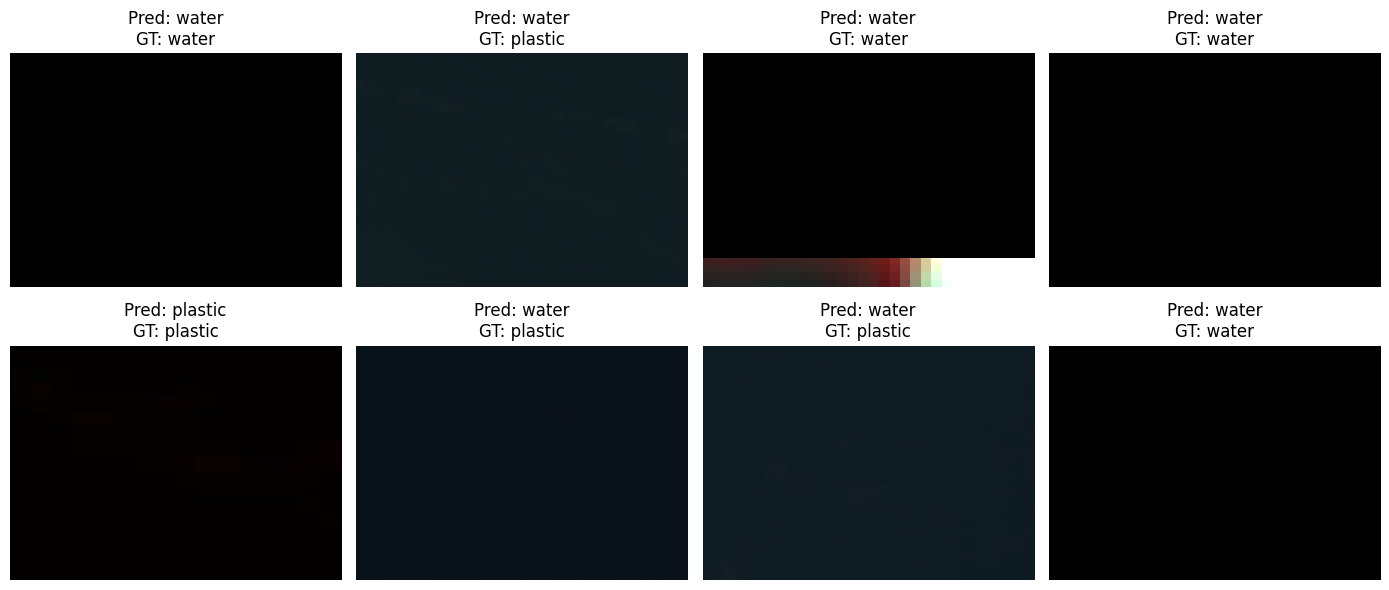

In [ ]:
import torch
import matplotlib.pyplot as plt

# Example class names (adjust if you have different labels)
class_names = ["water", "plastic"]

model.eval()  # Set model to evaluation mode

# Grab one batch of test data
images, labels = next(iter(test_loader))

# Move the batch to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

# Forward pass (no gradient calculation needed)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Convert some images back to CPU for plotting
images_cpu = images.cpu()
preds_cpu = preds.cpu()
labels_cpu = labels.cpu()

# Plot a few samples
num_samples_to_show = min(8, images_cpu.size(0))  # Show up to 8 images
plt.figure(figsize=(14, 6))

for i in range(num_samples_to_show):
    ax = plt.subplot(2, 4, i + 1)

    # If you have 12 bands, you can either select a subset (e.g., RGB bands)
    # or display a single band. Here's an example if you had 3-channel data:
    # (For 12-band images, you might adapt or omit direct visualization.)
    img = images_cpu[i]
    
    # Example: if your image is 3-channel, convert shape [C,H,W] -> [H,W,C]
    # If you truly have 12 bands, consider picking 3 representative bands:
    img = img[[3,2,1], :, :]  # e.g., first 3 bands, or any subset
    img_np = img.permute(1, 2, 0).numpy()

    plt.imshow(img_np, aspect='auto')  # Might need normalization or scaling
    plt.title(f"Pred: {class_names[preds_cpu[i].item()]}\n"
              f"GT: {class_names[labels_cpu[i].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


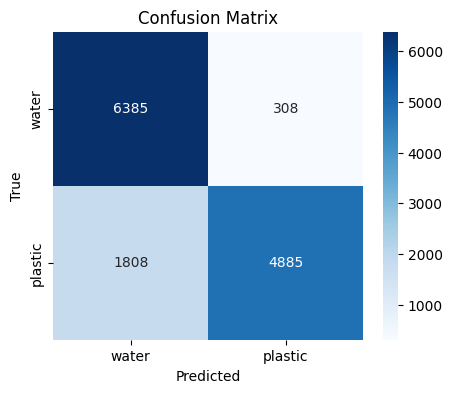

In [20]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move preds & labels to CPU numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally define class names (for a 2-class problem, e.g., water/plastic)
class_names = ["water", "plastic"]

# Plot using seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, 
    annot=True,       # show numbers in cells
    fmt='d',          # integer formatting
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
